In [1]:
from pylab import *
from scipy import *
from matplotlib.colors import LogNorm
from matplotlib import colors
from IPython.display import Image
from scipy.integrate import quad
from scipy import interpolate
from scipy.special import jn
from scipy.misc import derivative
from scipy.integrate import nquad

In [2]:
data_mean = loadtxt('/Users/jia/weaklensing/gplus/fulle_bins2D_cross_jk_final.dat')[:,5].reshape(25,-1).T
rp_bins = loadtxt('/Users/jia/weaklensing/gplus/fulle_bins2D_cross_jk_final.dat')[:,0].reshape(25,-1).T
pi_bins = loadtxt('/Users/jia/weaklensing/gplus/fulle_bins2D_cross_jk_final.dat')[:,1].reshape(25,-1).T

In [3]:
## make a reflection for negative r 
data_mean2=concatenate([data_mean,data_mean])
rp_bins2=concatenate([rp_bins,-rp_bins])
pi_bins2=concatenate([pi_bins,pi_bins])

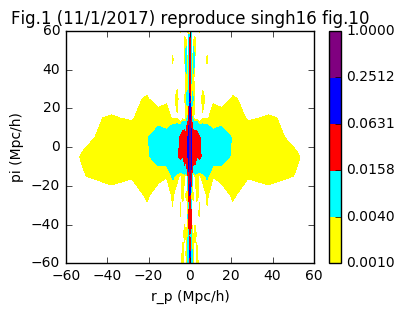

In [4]:
icolors=['yellow','cyan','red','blue','purple']
bounds=logspace(-3,0,6)

f=figure(figsize=(4,3))
ax=f.add_subplot(111)
CS=ax.contourf(rp_bins2, pi_bins2, data_mean2, bounds,colors=icolors)
ax.set_ylim(-60,60)
cbar = plt.colorbar(CS)
ax.set_xlim(-60,60)
ax.set_xlabel('r_p (Mpc/h)')
ax.set_ylabel('pi (Mpc/h)')
ax.set_title('Fig.1 (11/1/2017) reproduce singh16 fig.10')
show()

<img src="fig10b.jpg" style="width: 400px" align="left">

In [5]:
## dndz
#allz = loadtxt('../lowz/lowz.dat').T[2]
#print amax(allz),amin(allz) #0.16-0.36
#nz, zedges=histogram(allz, bins=linspace(zmin,zmax,51))
#istep = zedges[1]-zedges[0]
#zcenter = zedges [:-1] + 0.5 * istep
#dndz = nz.astype(float)/sum(nz)/istep
#save('dndz_lowz.npy',[zcenter,dndz])

In [6]:
zmin,zmax = 0.16, 0.36
zcenter,dndz = load('dndz_lowz.npy')
pz = interpolate.interp1d(zcenter,dndz,bounds_error=0,fill_value=0.)
zarr=linspace(0.1,0.4,1000)
pz_test = pz(zarr)

In [7]:
## cosmology WMAP9
h = 0.7
H0 = h*100
ob = 0.046
oc = 0.236
om = ob+oc
ol = 1-om#0.718
ns = 0.9646
s8 = 0.817

In [8]:
### constants and small functions
c = 299792.458#km/s
Gnewton = 6.674e-8#cgs cm^3/g/s^2

H = lambda z: H0*sqrt(om*(1+z)**3+ol)
H_inv = lambda z:  1/(H0*sqrt(om*(1+z)**3+ol))
Hcgs = lambda z: H(z)*3.24e-20
DC = lambda z: c*quad(H_inv, 0, z)[0]
W_fcn = lambda z: (pz(z) / DC(z))**2 / c * H(z) # dchi/dz = c/H
rho_cz = lambda z: 0.375*Hcgs(z)**2/pi/Gnewton

In [9]:
Wnorm = quad(W_fcn, zmin, zmax) [0]
W_arr = array([W_fcn(iz)/Wnorm for iz in zarr])
W = interpolate.interp1d(zarr,W_arr,bounds_error=0,fill_value=0.)

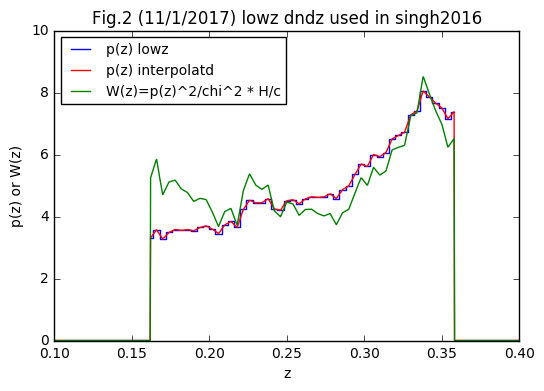

In [10]:
plot(zcenter, dndz, drawstyle='steps-mid',label='p(z) lowz')
plot(zarr,pz_test, 'r',label='p(z) interpolatd')
plot(zarr,W_arr, 'g',label='W(z)=p(z)^2/chi^2 * H/c')
xlabel('z')
ylabel('p(z) or W(z)')
ylim(0,10)
legend(fontsize=10,loc=0)
title('Fig.2 (11/1/2017) lowz dndz used in singh2016')
show()

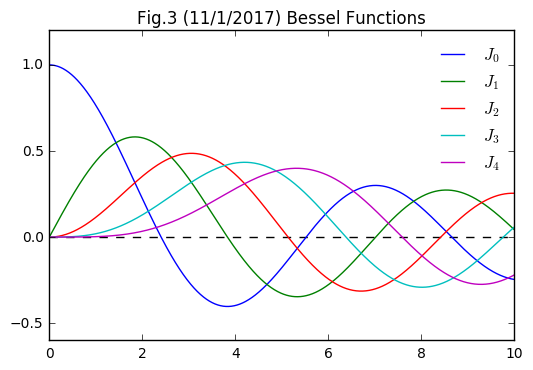

In [11]:
xarr=linspace(0,10,1001)
plot(xarr,zeros(len(xarr)),'k--')
for i in range(5):
    plot(xarr,jn(i,xarr),label='$J_%s$'%(i))
legend(frameon=0)
title('Fig.3 (11/1/2017) Bessel Functions')
show()

In [12]:
## interpolate Pk
Ptable = genfromtxt('/Users/jia/weaklensing/cmblensing/P_delta_Hinshaw')
aa = array([1/1.05**i for i in arange(33)])
zz = 1.0/aa-1 # redshifts
kk = Ptable.T[0] ## Mpc/h
iZ, iK = meshgrid(zz,kk)
Z, K = iZ.flatten(), iK.flatten()
Pk = Ptable[:,1:34].flatten()

### interpolate on actual k and P, without the h
Pmatter_interp = interpolate.CloughTocher2DInterpolator(array([K*h, Z]).T, 2.0*pi**2*Pk/(K*h)**3)
Pmatter = lambda k, z: Pmatter_interp (k, z)

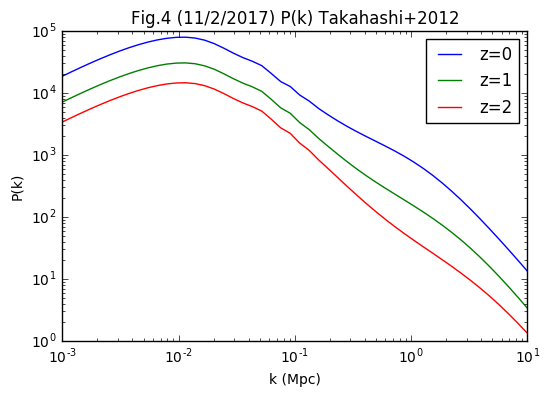

In [13]:
karr = logspace(-3,1)
f = figure()
ax=f.add_subplot(111)
for iz in linspace(0,2,3):
    ax.plot(karr, Pmatter(karr,iz),label='z=%i'%(iz))
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('k (Mpc)')
ax.set_ylabel('P(k)')
title('Fig.4 (11/2/2017) P(k) Takahashi+2012')
show()

In [14]:
## growth D(a)
zarr1=linspace(0,1,1001)
az = lambda z: 1.0/(1.0+z)
za = lambda a: 1.0/a-1
D_fcn = lambda a: H(za(a))/H0 * quad(lambda a: (om/a+ol*a**2)**(-1.5), 0, a)[0]
D1 = D_fcn(1)
D_arr = array([D_fcn (az(iz)) for iz in zarr1])/D1

###### logrithmic growth f=dln(D)/dln(a)
###### first do dD/da then x a/D
dnda_arr = array([derivative(D_fcn, az(iz), dx=1e-5) for iz in zarr1])
f_arr = az(zarr1)/D_arr * dnda_arr

Dinterp = interpolate.interp1d(zarr1,D_arr,bounds_error=0,fill_value=0.)
finterp = interpolate.interp1d(zarr1,f_arr,bounds_error=0,fill_value=0.)

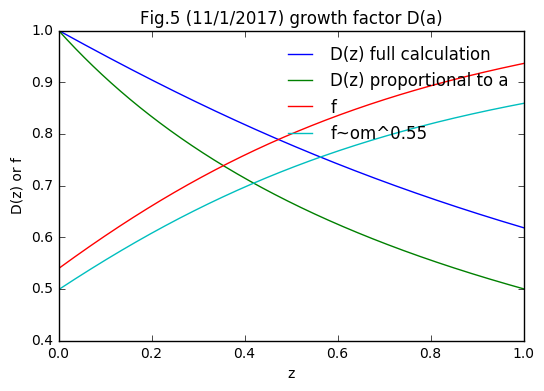

In [15]:
plot(zarr1,D_arr,label='D(z) full calculation')
plot(zarr1,az(zarr1),label='D(z) proportional to a')
plot(zarr1,f_arr,label='f')
plot(zarr1,(om*(1+zarr1)**3/ (H(zarr1)/H0)**2) ** .55 , label='f~om^0.55')
xlabel('z')
ylabel('D(z) or f')
legend(frameon=0)
title('Fig.5 (11/1/2017) growth factor D(a)')
show()

In [16]:
C1rhoc = 0.0134 #C1*rho_crit
bD = 1.77 #LOWZ measurement

kabs = lambda kz, kp: sqrt(kz**2+kp**2)
Ai=4.4
const = Ai*bD*C1rhoc*om/2.0/pi**2

def xi_gp(logkz,logkp,z,rp,PI): 
    if z>zmax or z<zmin:
        return 0
    else:
        kz,kp=10**logkz,10**logkp
        k=kabs(kz,kp)
        mu2=(kz/k)**2
        out=(1-mu2)*(kp/kz)*Pmatter(k,z)*jn(2,kp*rp)*(1.0+finterp(z)/bD*mu2)
        out*=cos(kz*PI)
        out*=W(z)/Dinterp(z)
        return out*const

In [17]:
irp=10
iPI=10
kz_arr = [xi_gp(ikz,-3,0.25,irp,iPI) for ikz in linspace(-5,1,7)]
print kz_arr,linspace(-5,1,7)

[0.13670688479354376, 0.013648756108131023, 0.0011111157955454591, 7.9286989823107687e-06, 5.911994844428537e-10, -5.7665504430919874e-14, 9.7020709066441698e-19] [-5. -4. -3. -2. -1.  0.  1.]


In [21]:
rp_arr = linspace(0.5, 60.5, 21)
Pi_arr = linspace(0.5, 60, 15)
rppi_arr = [[irp, ipi] for irp in rp_arr for ipi in Pi_arr]

out=load('out.npy').reshape(21,15).T


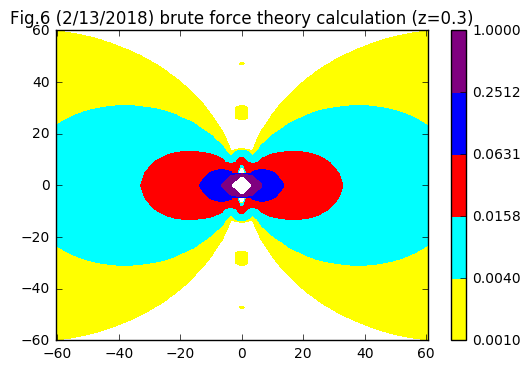

In [40]:
rp_bins_theory = list(-rp_arr[::-1])+list(rp_arr)
pi_bins_theory = list(-Pi_arr[::-1])+list(Pi_arr)

out_mirror = zeros((30,42))
out_mirror[:15,21:]=out[::-1]
out_mirror[15:,21:]=out
out_mirror[:,:21]=out_mirror[:,21:][:,::-1]

#imshow(out_mirror,interpolation='nearest')

CS1=contourf(rp_bins_theory, pi_bins_theory, out_mirror, bounds,colors=icolors)
colorbar(CS)
title('Fig.6 (2/13/2018) brute force theory calculation (z=0.3)')
show()

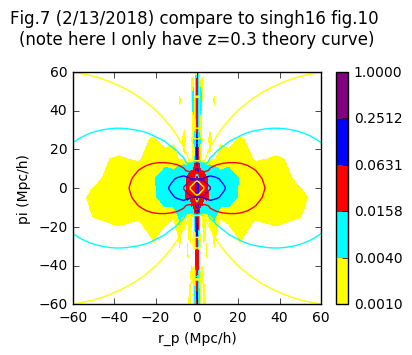

In [45]:
f=figure(figsize=(4,3))
ax=f.add_subplot(111)
CS=ax.contourf(rp_bins2, pi_bins2, data_mean2, bounds,colors=icolors)
ax.set_ylim(-60,60)
cbar = plt.colorbar(CS)
ax.set_xlim(-60,60)
ax.set_xlabel('r_p (Mpc/h)')
ax.set_ylabel('pi (Mpc/h)')
ax.contour(rp_bins_theory, pi_bins_theory, out_mirror, bounds,colors=icolors)
ax.set_title('Fig.7 (2/13/2018) compare to singh16 fig.10 \n(note here I only have z=0.3 theory curve)\n')
show()